# PCA report of US Arrest dataset

#### Loading the data

In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


The data needs to be summarized to determine the statistical properties of the columns.

In [315]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


As shown in the data above Assault column has a much larger mean value than those of other columns.

#### Preprocessing

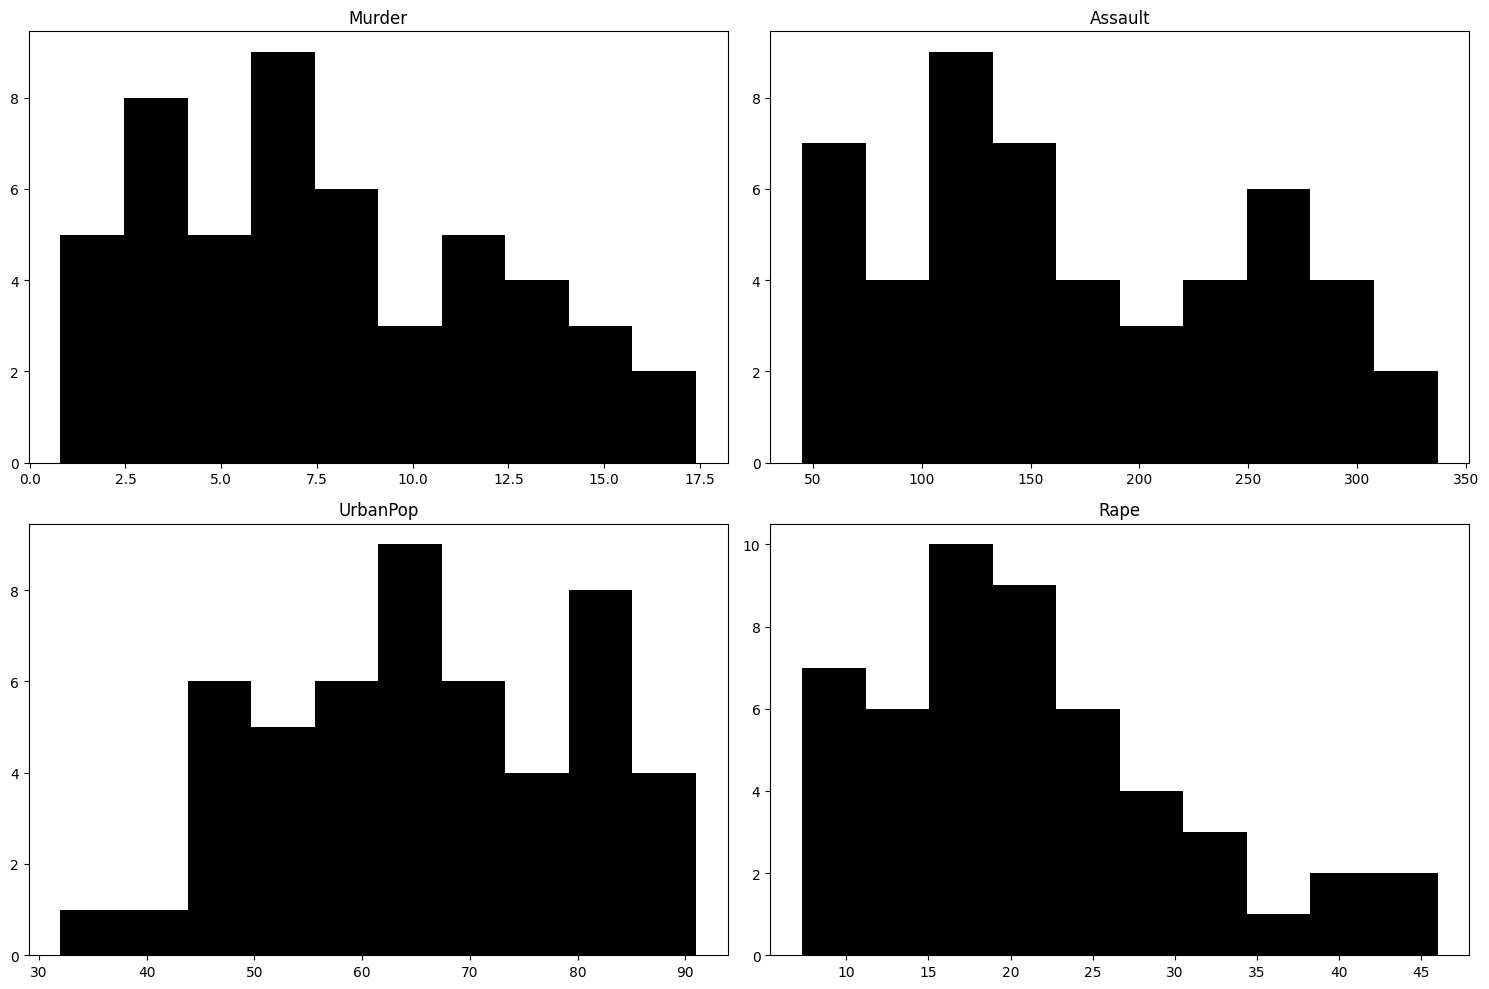

In [316]:
# drop country column
df_check = df.set_index('City')
df_check.head()
# Plot histograms
histograms = df_check.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()


As we can see from a quick inspection Assault and Rape cases seem to correlate 

### Exploring the data

In [317]:
#Sorted histrograms
fig1 = px.histogram(df.sort_values('Assault'), x="City", y="Assault")
fig2 = px.histogram(df.sort_values('Murder'), x="City", y="Murder")
fig3 = px.histogram(df.sort_values('UrbanPop'), x="City", y="UrbanPop")  
fig4 = px.histogram(df.sort_values('Rape'), x="City", y="Rape")

fig1.show()
fig2.show()
fig3.show()
fig4.show()

As the graphs above show, North Carolina, Georgia, and Nevada have the highest rates of Assault, Murder, and Rape respectively. With California having the largest urban population due to this, you would expect that California would feature more prominently in the top five of each graph, with its murder rate being compartively low when observing the other graphs.

#### Correlation Analysis

In [318]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
cities = df.index
corr_df = df.drop(["City"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

<AxesSubplot: >

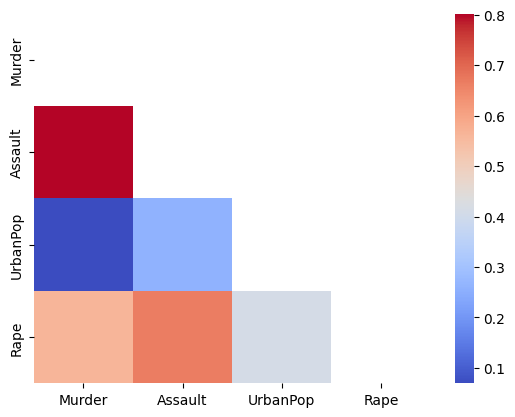

In [319]:
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

From the correlation plot it is evident that UrbanPop has relatively strong positive correlation on the rates at which crimes occur. It is also evident that there is strong negative correlation between murder and assault cases, this probably due to the fact that if a murder is recorded it can be assumed that the person was assaulted before they were murdered and them being dead would void the fact that they were assaulted therefore the murder would obviously not be recorded as an assault as well. Furthermore, there is a relatively strong negative correlation between assault and rape cases, as well as between murder and rape.

### Apply PCA

In [320]:
np.set_printoptions(precision=2)

X = df.drop(["City"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


The principal components are uncorrelated, showing us that PCA has summarized all the related information into a smaller numbner of variables.

In [321]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [322]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [323]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


#### Biplot of principal components

In [324]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

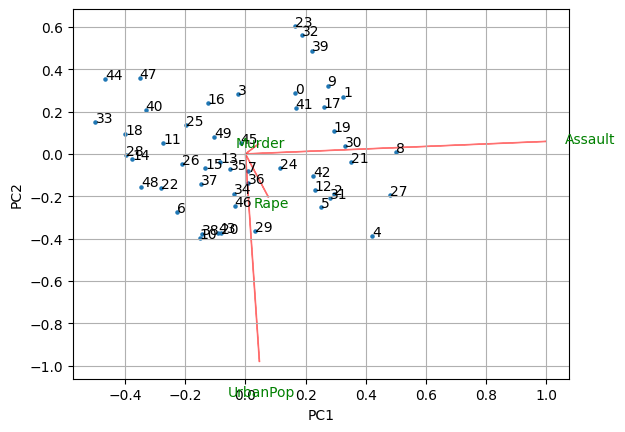

In [325]:
biplot(principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

As we can see from the biplot above the importance of each feature is denoted by the length of the arrow extending to its label. Knowing this it is evident that assault cases and the urban population are the most important features as the arrows of each are longest.

In [326]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


Upon further inspection of the prinicpal components it is clear that Assault has the highest importance in the first principle component, while UrbanPop has the highest importance in the second principle component.These findings correlate with those deduced from the biplot, however as noted in our summarised statistics earlier, the mean values for Assault and UrbanPop are much larger values than those of the other features, with Assault still roughly double the mean value of UrbanPop. This could mean that the other feature may 'swamp' the others, which would exclude them from the observations. 

#### Standardised data

Standardising the data so that features are not swamped by others.

In [327]:
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


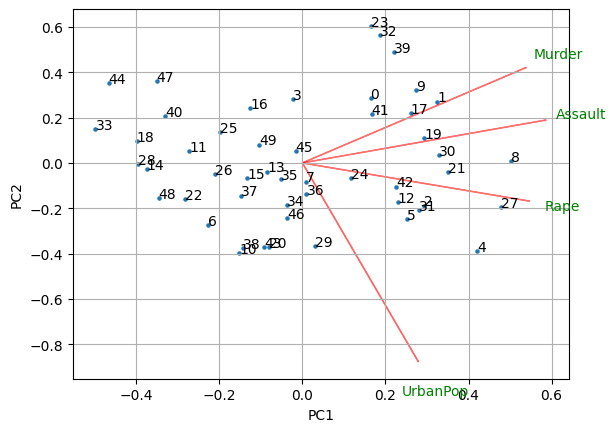

In [328]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

From the biplot above we can see that the standardised data results in a far better representation of the features of the dataset with the larger numbers non longer dominating. There are also four distinct features visible.

In [329]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


it is evident in the data above that each feature is of roughly equal importance except UrbanPop in the first principle component, however the UrbanPop feature in the second principle component is the most dominant feature now, followed by the Murder feature.

Text(0.5, 1.0, 'Cumulative Explained Variance')

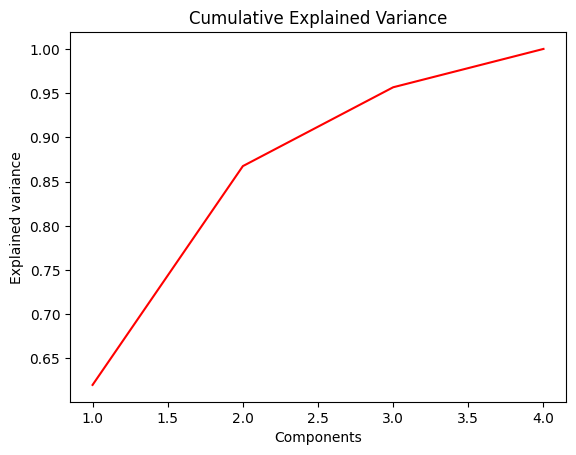

In [330]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

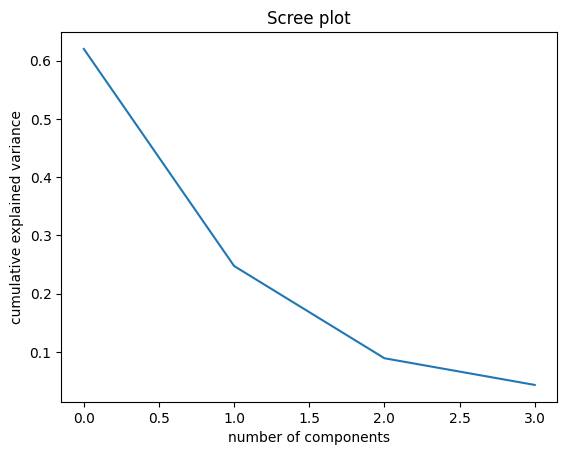

In [331]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

# Cluster analysis

### Hierarchical clustering

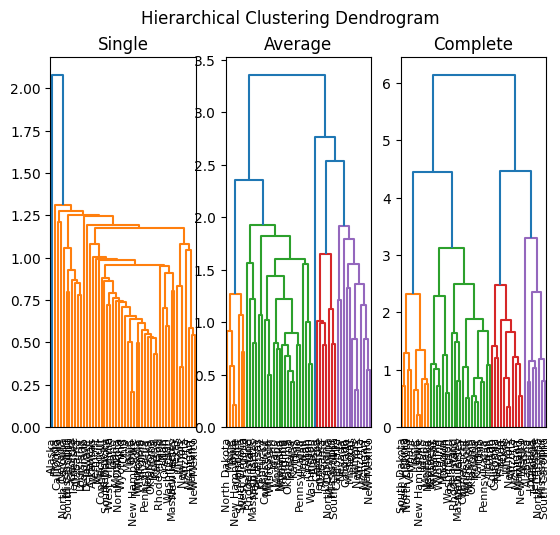

In [332]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

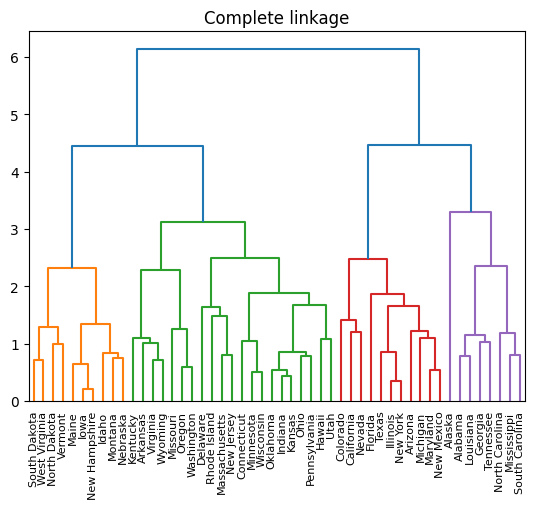

In [333]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

The complete linkage dendrogram provides the most discrete clusters for analysis.

### K-means

##### Selecting K

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Group 0: ['Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Massachusetts', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']


Group 1: ['Alabama', 'Arkansas', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


Group 2: ['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']


Group 3: ['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']




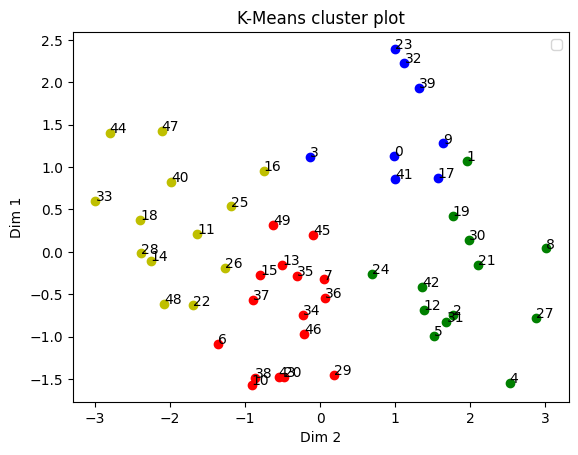

In [334]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]
group2 = np.array(cities)[group2_indices]
group3 = np.array(cities)[group3_indices]


print("Group 0: {}\n\n".format([df.loc[x]["City"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["City"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["City"] for x in group2]))
print("Group 3: {}\n\n".format([df.loc[x]["City"] for x in group3]))

c:\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Group 0: ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


Group 1: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming']


Group 2: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']


Group 3: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']




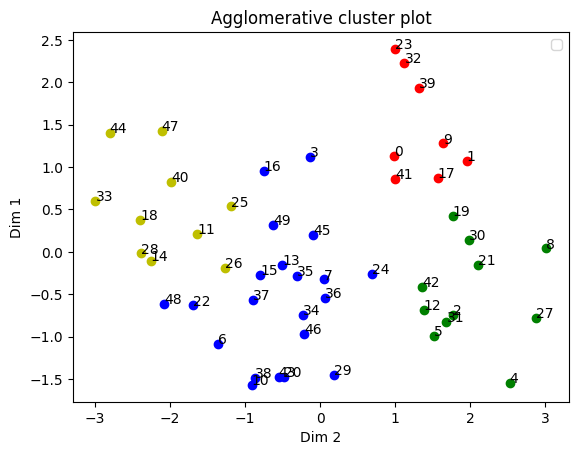

In [335]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')
cluster_labels = cluster.fit_predict(pca_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("Agglomerative cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]
group2 = np.array(cities)[group2_indices]
group3 = np.array(cities)[group3_indices]


print("Group 0: {}\n\n".format([df.loc[x]["City"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["City"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["City"] for x in group2]))
print("Group 3: {}\n\n".format([df.loc[x]["City"] for x in group3]))

In [336]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]
group2 = np.array(cities)[group2_indices]
group3 = np.array(cities)[group3_indices]


print("Group 0: {}\n\n".format([df.loc[x]["City"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["City"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["City"] for x in group2]))
print("Group 3: {}\n\n".format([df.loc[x]["City"] for x in group3]))

Group 0: ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


Group 1: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming']


Group 2: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']


Group 3: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']




Through both k-means and agglomerative clustering returned the same clusters for each, with groupos 2 and 3 being identical to each other in both clustering methods.